In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [112]:
np.random.seed(42)
data1 = noisy_circle(50, 0.2, 0, 0, 3 )
data2 = noisy_circle(50, 0.2, 8, 0, 5)
data3 = noisy_circle(50, 0.2, 4, 15, 4 )
A = np.concatenate([data1, data2, data3])
data1 = noisy_circle(50, 0.2, 0, 0, 3 )
data2 = noisy_circle(50, 0.2, 7, 0, 4)
data3 = noisy_circle(50, 0.2, 4, 15, 5 )
B = np.concatenate([data1, data2, data3])

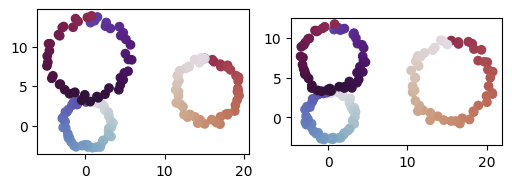

In [113]:
plt.figure(figsize = (6, 3))
plt.subplot(1, 2, 1)
plt.scatter(A[:,1],A[:,0], c = range(A.shape[0]), cmap = 'twilight')
plt.gca().set_aspect('equal', adjustable='box')
plt.subplot(1, 2, 2)
plt.scatter(B[:,1],B[:,0], c = range(B.shape[0]), cmap = 'twilight')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [83]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic 
H_all = [PH(x) for x in tqdm([A,B])]
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]
y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])
# similarity with kernel
h = 0.25
K0 = topo_util.get_kernel(A, h)
L0 = topo_util.symmetric_laplacian(K0)
K0 /= K0.sum(-1).reshape(-1, 1)
K1 = topo_util.get_kernel(B, h)
L1 = topo_util.symmetric_laplacian(K1)
K1 /= K1.sum(-1).reshape(-1, 1)
y0_imputed = topo_util.impute_laplacian(y0, L0)
y1_imputed = topo_util.impute_laplacian(y1, L1)
y0 = y0_imputed; y1 = y1_imputed;

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.72s/it]


In [98]:
import topf
topf_all = [topf.topf(x, return_dict = True, complex_type = 'rips', fixed_num_features = [0, 10]) for x in tqdm([A, B])]
y0 = topf_all[0][0]
y1 = topf_all[1][0]
df1, df2 = [pandas.DataFrame({"b" : x[1]['birth_times'], "d" : x[1]['death_times'], "pers" : np.array(x[1]['death_times']) - np.array(x[1]['birth_times'])}) for x in topf_all]
p_spt, q_spt = df1.iloc[:, :2].values, df2.iloc[:, :2].values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.21s/it]


In [99]:
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
pi = ot.emd(p, q, C)

In [129]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

In [130]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "euclidean"); C_v0 /= np.mean(C_v0)
# C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "euclidean"); C_v1 /= np.mean(C_v1)
# C_v1 = np.exp(-C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= np.mean(C_pd)

In [131]:
alpha = 0.5
v0 = p
v1 = q
w0 = ot.unif(y0.shape[0])
w1 = ot.unif(y1.shape[0])

importlib.reload(tpot)
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                          C_v0, C_v1, C_pd, 
                          alpha = alpha, beta = 1, print_iter = 10, iter = 100, 
                          eps_s = 0.001, eps_f = 0.001,
                          solver = "sinkhorn",
                          )

Iteration 0,	 obj = 0.15964798520718054,	 obj_terms = {'coot': 0.06760358550196736, 'ot': 0.0006438035561238748, 'gw': 0.0914005961490893}
Iteration 10,	 obj = 0.032500328546496746,	 obj_terms = {'coot': 0.005986551198830172, 'ot': 0.02083949273673994, 'gw': 0.005674284610926629}
Iteration 20,	 obj = 0.032500276982343645,	 obj_terms = {'coot': 0.005986485825679887, 'ot': 0.02083953451199057, 'gw': 0.005674256644673187}
is_converged, obj = 0.03250027060635014, obj_new = 0.032500269662213255


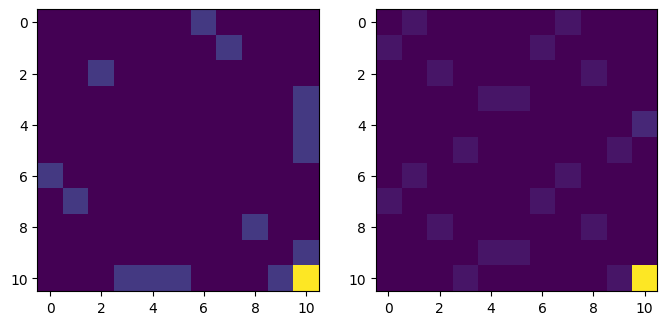

In [133]:
plt.subplot(1, 2, 1)
plt.imshow(pi)
plt.subplot(1, 2, 2)
plt.imshow(pi_f)

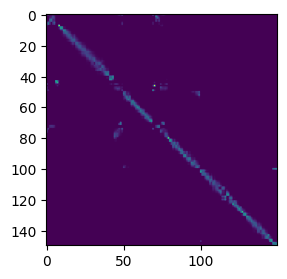

In [134]:
plt.figure(figsize = (3, 3))
plt.imshow(pi_s)

In [135]:
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
Q[np.isnan(Q)] = 0
Q_pd[np.isnan(Q_pd)] = 0

/tmp/ipykernel_1327463/3284110093.py:3: RuntimeWarning:

invalid value encountered in divide



In [136]:
len(p_spt), len(q_spt)

(10, 10)

In [137]:
sizes_p = 10 + np.zeros((len(p_spt)))
sizes_q = 10 + np.zeros((len(q_spt)))
sizes_p[-1], sizes_p[-2],sizes_p[-3] = 100,100,100
sizes_q[-1], sizes_q[-2],sizes_q[-3] = 100,100,100

color_p =  np.zeros((len(p_spt)))
color_q =  np.zeros((len(q_spt)))
color_p[-1], color_p[-2],color_p[-3] = 1,2,3
color_q[-1], color_q[-2],color_q[-3] = 1,2,3

Text(0.5, 1.0, 'Geometric cycle matching')

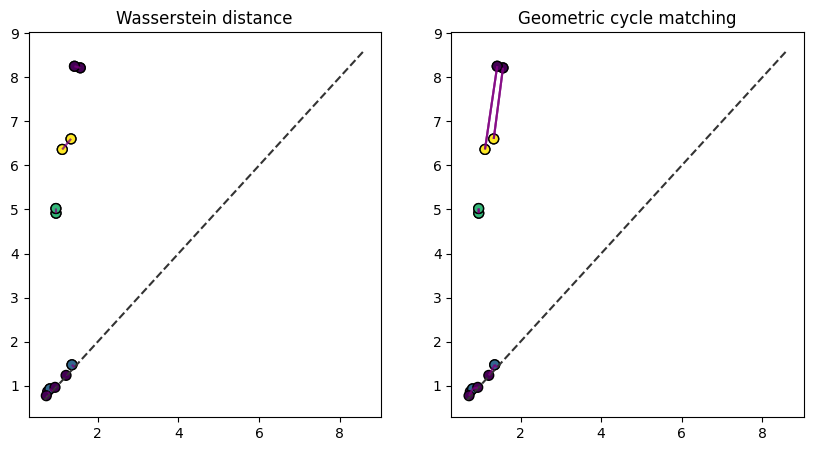

In [142]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
# pd.plot_pd_connections(p, q, p_spt, q_spt, pi, color_p, color_q, sizes_p, sizes_q)
pd.plot_pd(p_spt, color = color_p, cmap = "viridis", plot_diagonal = False)
pd.plot_pd(q_spt, color = color_q, cmap = "viridis")
pd.plot_pd_connections(p, q, p_spt, q_spt, pi)
plt.title("Wasserstein distance")
plt.subplot(1, 2, 2)
# pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f, color_p, color_q, sizes_p, sizes_q)
pd.plot_pd(p_spt, color = color_p, cmap = "viridis", plot_diagonal = False)
pd.plot_pd(q_spt, color = color_q, cmap = "viridis")
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f)
plt.title("Geometric cycle matching")
# plt.savefig('outputs/mathcing_ex4.svg', dpi=300)

In [143]:
colour_source = list(np.zeros((len(A),)))
colour_target = list(np.zeros((len(A),)))
for l in range(1,4):
    index_source = np.where((y0[:, -l] >0.5 ))[0]
    for el in index_source:
        colour_source[el] =  l
    index_target = np.where((y1[:, -l] >0.5 ))[0]
    for el in index_target:
        colour_target[el] = l

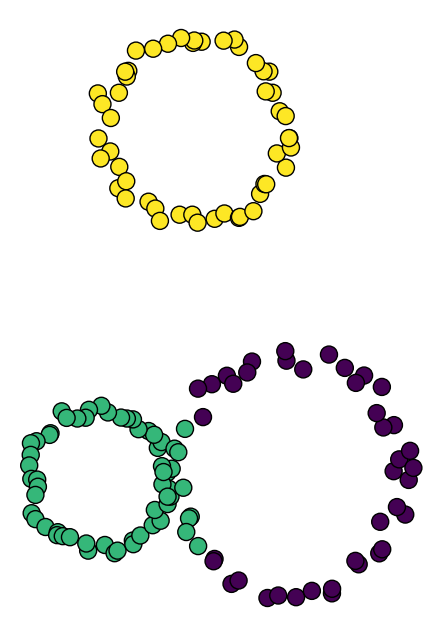

In [144]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = colour_source, s=150,edgecolors='black', vmax=3, vmin=0)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/source_ex4.svg', dpi=300)
plt.show()

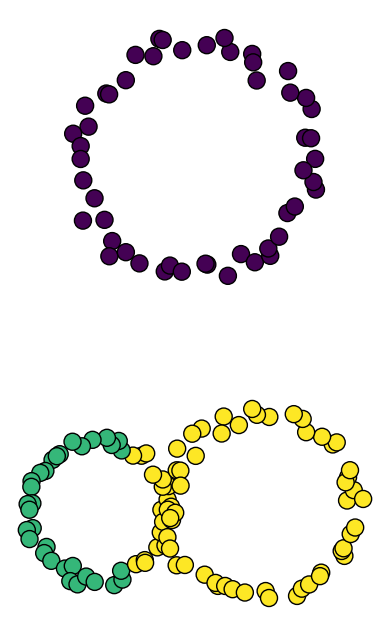

In [145]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = colour_target, s=150,edgecolors='black', vmax=3, vmin=0)
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/target_ex4.svg', dpi=300)
plt.show()